In [1]:
import sqlite3
import pandas as pd

def send_sql(db, sql):
    c = sqlite3.connect(db)
    df = pd.read_sql(sql, c)
    c.close()
    return df

def merge(df1, df2, merge_key):
    d1 = list(df1.T.to_dict().values())
    d2 = list(df2.T.to_dict().values())
    merge_d = {}
    keys = set()
    for key in d1[0]:
        keys.add(key)
    for key in d2[0]:
        keys.add(key)
    keys.remove(merge_key)
    for data in d1:
        key = data[merge_key]
        if key not in merge_d:
            merge_d[key] = {}
            for k in keys:
                merge_d[key][k] = 0
        for k in data:
            merge_d[key][k] = data[k]
    for data in d2:
        key = data[merge_key]
        if key not in merge_d:
            merge_d[key] = {}
            for k in keys:
                merge_d[key][k] = 0
        for k in data:
            merge_d[key][k] = data[k]
    return pd.DataFrame(merge_d).T

In [2]:
send_sql("weather.db", "select * from weather limit 1").columns

Index(['YR', 'MT', 'DY', 'TEMP MAX', 'TEMP MIN', 'TEMP AVG', 'TEMP DEP',
       'TEMP HDD', 'TEMP CDD', 'PCPN WTR', 'SNOW SNW', 'SNOW DPTH',
       'WIND AVG SPD', 'WIND MX SPD', 'WIND 2MIN DIR', 'SUNSHINE MIN',
       'SUNSHINE PSBL', 'SKY S-S', 'SKY WX', 'PK SPD', 'PK DR'],
      dtype='object')

In [3]:
sql = '''
select YR, MT, avg("TEMP AVG") as TEMP, avg("PCPN WTR") as RAIN, 
avg("SNOW SNW") as SNOW, avg("SNOW DPTH") as DPTH, avg("WIND AVG SPD") as WIND from weather 
group by MT
order by MT
'''
df1 = send_sql("weather.db", sql)
df2 = send_sql("cost.db", "select YR, MT, sum(AMOUNT) as AMOUNT from cost group by MT order by MT")
df = df1.merge(df2)
sql = '''
select YR, MT, count() as SNOW_DAY from weather 
where "SNOW SNW" > 0.05
group by MT
order by MT
'''
df1 = send_sql("weather.db", sql)

df2 = merge(df, df1, 'MT')
df = df.merge(df2[['MT', 'SNOW_DAY']])
df["AVG_SNOW_PER_SNOW_DAY"] = 0
for i in range(51):
    if df["SNOW_DAY"].loc[i] != 0:
        df["AVG_SNOW_PER_SNOW_DAY"].loc[i] = df["SNOW"].loc[i] / df["SNOW_DAY"].loc[i]
df

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,YR,MT,TEMP,RAIN,SNOW,DPTH,WIND,AMOUNT,SNOW_DAY,AVG_SNOW_PER_SNOW_DAY
0,2015,2015/01,20.096774,0.021290,0.329032,1.387097,7.077419,478856.70,11,0.029912
1,2015,2015/02,11.178571,0.019286,0.382143,6.285714,8.007143,1013344.93,8,0.047768
2,2015,2015/03,34.838710,0.024516,0.135484,1.709677,7.196774,563367.33,3,0.045161
3,2015,2015/04,48.533333,0.146000,0.000000,0.000000,8.466667,607092.10,0,0.000000
4,2015,2015/05,60.483871,0.134839,0.000000,0.000000,8.283871,137855.22,0,0.000000
5,2015,2015/06,67.466667,0.105000,0.000000,0.000000,6.123333,161803.03,0,0.000000
6,2015,2015/07,70.935484,0.161935,0.000000,0.000000,5.512903,110880.96,0,0.000000
7,2015,2015/08,69.903226,0.132258,0.000000,0.000000,5.858065,116129.93,0,0.000000
8,2015,2015/09,67.333333,0.199667,0.000000,0.000000,6.746667,223710.13,0,0.000000
9,2015,2015/10,51.806452,0.088065,0.000000,0.000000,7.561290,176129.13,0,0.000000


In [4]:
c = sqlite3.connect("../../../../../month_cost_weather.db")
df.to_sql('data', c, if_exists = 'replace', index = False)
c.close()

In [5]:
def threshold(col, value):
    sql = '''
    select YR, avg(AMOUNT) as AMOUNT, avg(''' + col + ''') as ''' + col + ''' from data 
    where ''' + col + ''' <= ''' + str(value) + '''
    group by YR
    '''
    df1 = send_sql("../../../../../month_cost_weather.db", sql)
    sql = '''
    select YR, avg(AMOUNT) as AMOUNT, avg(''' + col + ''') as ''' + col + ''' from data 
    where ''' + col + ''' > ''' + str(value) + '''
    group by YR
    '''
    df2 = send_sql("../../../../../month_cost_weather.db", sql)
    df1["AMOUNT"] = df1["AMOUNT"].astype("int")
    df2["AMOUNT"] = df2["AMOUNT"].astype("int")
    return (df1, df2)

In [6]:
(df1, df2) = threshold("TEMP", 32)
df1

,YR,AMOUNT,TEMP
0,2015,746100,15.637673
1,2016,751631,23.357805
2,2017,926500,23.129032
3,2018,616182,25.688633
4,2019,648005,20.941500


In [7]:
df2

,YR,AMOUNT,TEMP
0,2015,381283,54.882473
1,2016,268925,58.282557
2,2017,321424,53.612734
3,2018,383119,57.649328


In [8]:
(df1, df2) = threshold("DPTH", 0)
df1

,YR,AMOUNT,DPTH
0,2015,219085,0.0
1,2016,170044,0.0
2,2017,212641,0.0
3,2018,277199,0.0


In [9]:
df2 - df1

,YR,AMOUNT,DPTH
0,0.0,535202.0,2.014562
1,0.0,526937.0,1.781965
2,0.0,628889.0,1.049827
3,0.0,367215.0,0.719201
4,NaN,NaN,NaN


In [10]:
(df1, df2) = threshold("SNOW", 0)
df1

,YR,AMOUNT,SNOW
0,2015,219085,0.0
1,2016,170044,0.0
2,2017,214842,0.0
3,2018,277199,0.0


In [11]:
df2 - df1

,YR,AMOUNT,SNOW
0,0.0,535202.0,0.244407
1,0.0,526937.0,0.286843
2,0.0,497829.0,0.164604
3,0.0,367215.0,0.277894
4,NaN,NaN,NaN


In [12]:
import numpy as np

df = send_sql("../../../../../month_cost_weather.db", "select * from data")
df["1"] = 1
explanatory = ['TEMP', 'SNOW', 'SNOW_DAY', 'RAIN', 'WIND', '1']

res = np.linalg.lstsq(df[explanatory], df["AMOUNT"], rcond=None)

c = res[0]
s = "AMOUNT = "
for idx in range(len(explanatory)):
    s += str(int(c[idx])) + " * " + explanatory[idx] + " + "

print(s[:-2])

df['FIT'] = 0
for idx in range(len(explanatory)):
    df['FIT'] += df[explanatory[idx]] * c[idx]

df.plot.scatter(x='AMOUNT', y='FIT')

(df['FIT'] - df['AMOUNT']).std()

AMOUNT = -7503 * TEMP + 553100 * SNOW + 6699 * SNOW_DAY + 442143 * RAIN + 32150 * WIND + 416231 * 1 


257034.2325864192

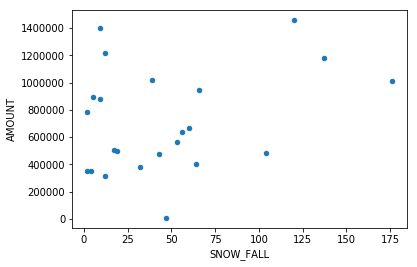

In [13]:
sql = '''
select YR, MT, sum("SNOW DPTH") as SNOW_FALL, count() as SNOW_DAY from weather 
where "SNOW DPTH" > 0
group by MT
order by MT
'''
df1 = send_sql("weather.db", sql)
df2 = send_sql("cost.db", "select YR, MT, sum(AMOUNT) as AMOUNT from cost group by MT order by MT")
df = df1.merge(df2)
df.plot.scatter(x = "SNOW_FALL", y = "AMOUNT")

Text(0, 0.5, '')

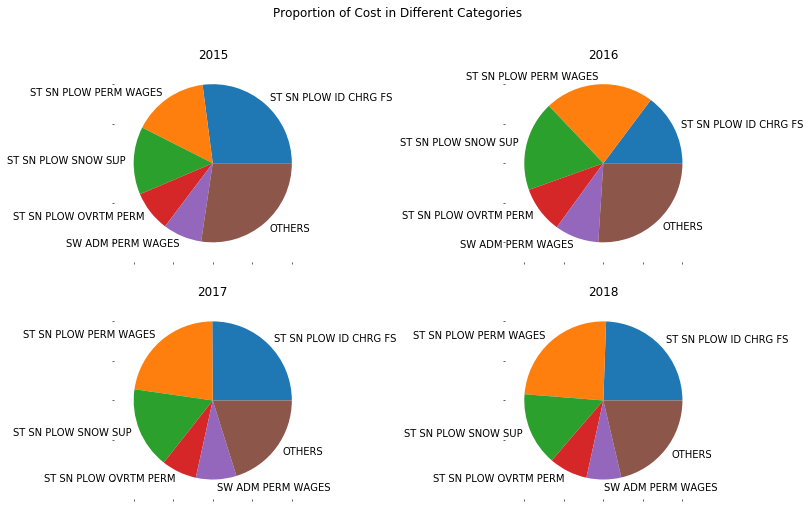

In [14]:
c = sqlite3.connect('cost.db')
sql = '''
select DESCRIPTION, sum("AMOUNT") as expense15 from cost where YEAR = 2015 group by DESCRIPTION order by expense15 desc
'''
df1 = pd.read_sql(sql, c)
sql = '''
select sum("AMOUNT") as expense16, DESCRIPTION from cost where YEAR = 2016 group by DESCRIPTION order by expense16 desc
'''
df2 = pd.read_sql(sql, c)
sql = '''
select sum("AMOUNT") as expense17, DESCRIPTION from cost where YEAR = 2017 group by DESCRIPTION order by expense17 desc
'''
df3 = pd.read_sql(sql, c)
sql = '''
select sum("AMOUNT") as expense18, DESCRIPTION from cost where YEAR = 2018 group by DESCRIPTION order by expense18 desc
'''
df4 = pd.read_sql(sql, c)
c.close()
df = df1.merge(df2).merge(df3).merge(df4)
df["SUM"] = df.sum(axis = 1)
df = df.sort_values("SUM", ascending = False)
df = df[df["SUM"] > 10000]

def group_other(s, n):
    index = list(s.index)
    value = list(s)
    index = index[:n] + ['OTHERS']
    value = value[:n] + [sum(value[n:])]
    r = pd.Series(value, index = index)
    return r
s15 = df['expense15']
s15.index = df['DESCRIPTION']
s15 = group_other(s15, 5)
s16 = df['expense16']
s16.index = df['DESCRIPTION']
s16 = group_other(s16, 5)
s17 = df['expense17']
s17.index = df['DESCRIPTION']
s17 = group_other(s17, 5)
s18 = df['expense18']
s18.index = df['DESCRIPTION']
s18 = group_other(s18, 5)

import matplotlib.pyplot as plt
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize = (12, 8))
f.suptitle('Proportion of Cost in Different Categories')
f.subplots_adjust(wspace=0.4, hspace=0.2)
s15.plot.pie(x = 'DESCRIPTION', ax = ax1, title = '2015').set_ylabel(None)
s16.plot.pie(x = 'DESCRIPTION', ax = ax2, title = '2016').set_ylabel(None)
s17.plot.pie(x = 'DESCRIPTION', ax = ax3, title = '2017').set_ylabel(None)
s18.plot.pie(x = 'DESCRIPTION', ax = ax4, title = '2018').set_ylabel(None)


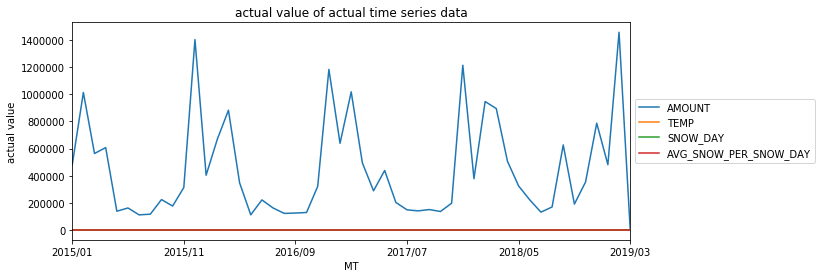

In [15]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
df = df[['MT', 'AMOUNT', 'TEMP', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY']]
ax = df.plot.line(x = 'MT', figsize = (10,4), title = 'actual value of actual time series data')
ax.set_ylabel('actual value')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

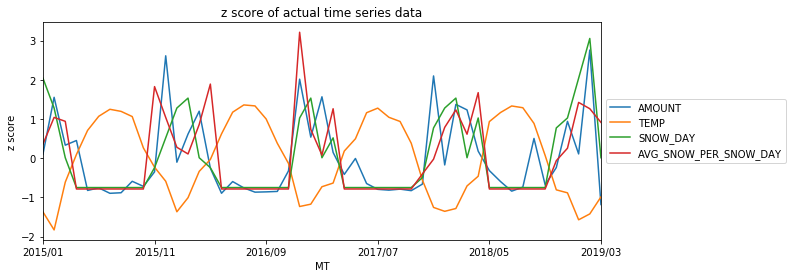

In [16]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
for name in ['TEMP', 'SNOW', 'AMOUNT', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY']:
    #df[name] = list(np.convolve(np.asarray(list(df[name])), np.array([1, 1, 1]) / 3, 'same'))
    df[name] = (df[name] - df[name].mean()) / df[name].std()
df = df[['MT', 'AMOUNT', 'TEMP', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY']]
ax = df.plot.line(x = 'MT', figsize = (10,4), title = 'z score of actual time series data')
ax.set_ylabel('z score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

AMOUNT = -0.2756011562334408 * TEMP + 0.2859704891662075 * SNOW_DAY + 0.20163759377855056 * AVG_SNOW_PER_SNOW_DAY + 4.058120180760443e-16 * 1 


0.70968328091807

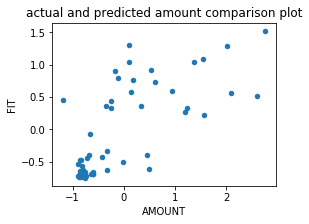

In [17]:
df["1"] = 1
explanatory = ['TEMP', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY', '1']

res = np.linalg.lstsq(df[explanatory], df["AMOUNT"], rcond=None)

c = res[0]
s = "AMOUNT = "
for idx in range(len(explanatory)):
    s += str(c[idx]) + " * " + explanatory[idx] + " + "

print(s[:-2])

df['FIT'] = 0
for idx in range(len(explanatory)):
    df['FIT'] += df[explanatory[idx]] * c[idx]

df.plot.scatter(x='AMOUNT', y='FIT', figsize = (4,3), title = 'actual and predicted amount comparison plot')

(df['FIT'] - df['AMOUNT']).std()

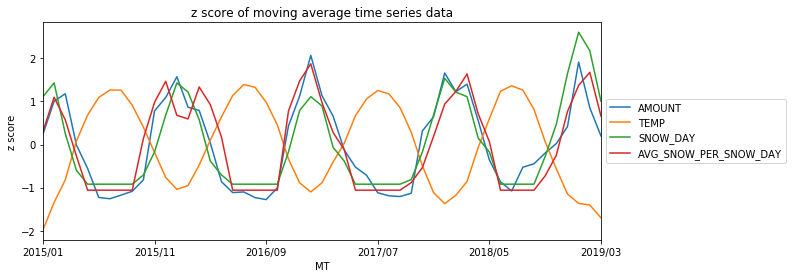

In [18]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
for name in ['TEMP', 'SNOW', 'AMOUNT', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY', 'RAIN', 'WIND']:
    df[name] = list(np.convolve(np.asarray(list(df[name])), np.array([1, 1, 1]) / 3, 'same'))
    df[name] = (df[name] - df[name].mean()) / df[name].std()
df = df[['MT', 'AMOUNT', 'TEMP', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY']]
ax = df.plot.line(x = 'MT', figsize = (10, 4), title = 'z score of moving average time series data')
ax.set_ylabel('z score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

AMOUNT = -0.25332516332651184 * TEMP + 0.21403014830948522 * SNOW_DAY + 0.5045940428926535 * AVG_SNOW_PER_SNOW_DAY + 6.480173238395667e-16 * 1 


0.3704501485395998

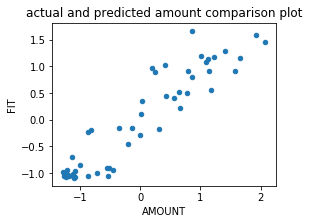

In [19]:
df["1"] = 1
explanatory = ['TEMP', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY', '1']

res = np.linalg.lstsq(df[explanatory], df["AMOUNT"], rcond=None)

c = res[0]
s = "AMOUNT = "
for idx in range(len(explanatory)):
    s += str(c[idx]) + " * " + explanatory[idx] + " + "

print(s[:-2])

df['FIT'] = 0
for idx in range(len(explanatory)):
    df['FIT'] += df[explanatory[idx]] * c[idx]

df.plot.scatter(x='AMOUNT', y='FIT', figsize = (4,3), title = 'actual and predicted amount comparison plot')

(df['FIT'] - df['AMOUNT']).std()

In [20]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
for name in ['TEMP', 'SNOW', 'AMOUNT', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY', 'RAIN', 'WIND']:
    df[name] = list(np.convolve(np.asarray(list(df[name])), np.array([1, 1, 1]) / 3, 'same'))
df = df[['MT', 'AMOUNT', 'TEMP', 'SNOW_DAY', 'AVG_SNOW_PER_SNOW_DAY']]
df['AMOUNT'] = df['AMOUNT'] / 1000000

AMOUNT = 11.638394845243285 * AVG_SNOW_PER_SNOW_DAY + 0.2044263453765616 * 1 


0.10716535809934281

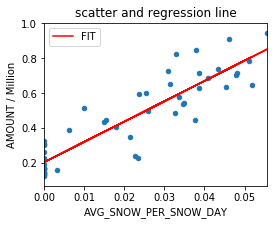

In [21]:
df["1"] = 1
explanatory = ['AVG_SNOW_PER_SNOW_DAY', '1']

res = np.linalg.lstsq(df[explanatory], df["AMOUNT"], rcond=None)

c = res[0]
s = "AMOUNT = "
for idx in range(len(explanatory)):
    s += str(c[idx]) + " * " + explanatory[idx] + " + "

print(s[:-2])

df['FIT'] = 0
for idx in range(len(explanatory)):
    df['FIT'] += df[explanatory[idx]] * c[idx]

ax = df.plot.scatter(x = 'AVG_SNOW_PER_SNOW_DAY', y = 'AMOUNT', figsize = (4,3), title = 'scatter and regression line')
df.plot.line(x = 'AVG_SNOW_PER_SNOW_DAY', y = 'FIT', c = 'red', ax = ax)
ax.set_ylabel('AMOUNT / Million')
(df['FIT'] - df['AMOUNT']).std()

AMOUNT = -0.011810897341448185 * TEMP + 0.9868244918240491 * 1 


0.11929350416863918

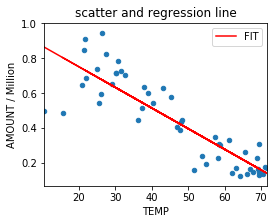

In [22]:
df["1"] = 1
explanatory = ['TEMP', '1']

res = np.linalg.lstsq(df[explanatory], df["AMOUNT"], rcond=None)

c = res[0]
s = "AMOUNT = "
for idx in range(len(explanatory)):
    s += str(c[idx]) + " * " + explanatory[idx] + " + "

print(s[:-2])

df['FIT'] = 0
for idx in range(len(explanatory)):
    df['FIT'] += df[explanatory[idx]] * c[idx]

ax = df.plot.scatter(x = 'TEMP', y = 'AMOUNT', figsize = (4,3), title = 'scatter and regression line')
df.plot.line(x = 'TEMP', y = 'FIT', c = 'red', ax = ax)
ax.set_ylabel('AMOUNT / Million')
(df['FIT'] - df['AMOUNT']).std()

AMOUNT = 0.06892186809829566 * SNOW_DAY + 0.24067163558724364 * 1 


0.11863801798261711

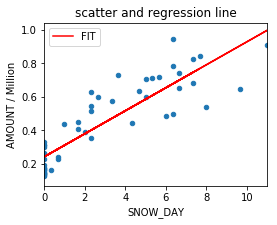

In [23]:
df["1"] = 1
explanatory = ['SNOW_DAY', '1']

res = np.linalg.lstsq(df[explanatory], df["AMOUNT"], rcond=None)

c = res[0]
s = "AMOUNT = "
for idx in range(len(explanatory)):
    s += str(c[idx]) + " * " + explanatory[idx] + " + "

print(s[:-2])

df['FIT'] = 0
for idx in range(len(explanatory)):
    df['FIT'] += df[explanatory[idx]] * c[idx]

ax = df.plot.scatter(x = 'SNOW_DAY', y = 'AMOUNT', figsize = (4,3), title = 'scatter and regression line')
df.plot.line(x = 'SNOW_DAY', y = 'FIT', c = 'red', ax = ax)
ax.set_ylabel('AMOUNT / Million')
(df['FIT'] - df['AMOUNT']).std()

Text(0, 0.5, 'AMOUNT / Million')

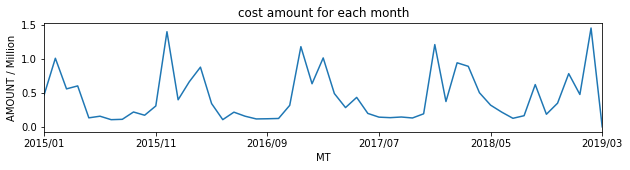

In [24]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
df = df[['AMOUNT', 'MT']]
df['AMOUNT'] = df['AMOUNT'] / 1000000
ax = df.plot.line(x = 'MT', figsize = (10, 2), title = 'cost amount for each month', legend = None)
ax.set_ylabel('AMOUNT / Million')

Text(0, 0.5, 'TEMP / F')

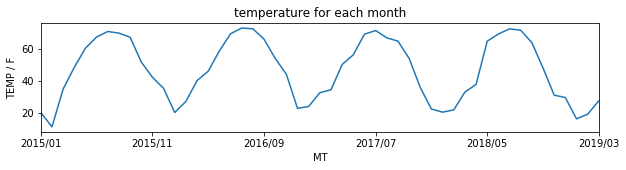

In [25]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
df = df[['TEMP', 'MT']]
ax = df.plot.line(x = 'MT', figsize = (10, 2), title = 'temperature for each month', legend = None)
ax.set_ylabel('TEMP / F')

Text(0, 0.5, 'SNOW_DAY')

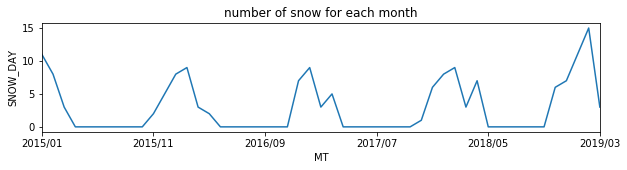

In [26]:
df = send_sql("../../../../../month_cost_weather.db", "select * from data")
df = df[['SNOW_DAY', 'MT']]
ax = df.plot.line(x = 'MT', figsize = (10, 2), title = 'number of snow for each month', legend = None)
ax.set_ylabel('SNOW_DAY')